# Zarr ECCO ds - cleaned version

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(20)
#cluster.adapt(minimum=2, maximum=10)
client = cluster.get_client()

In [4]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.f4b32e2b46bf48a2ae4d05176d5620f4 Dashboard: /services/dask-gateway/clusters/prod.f4b32e2b46bf48a2ae4d05176d5620f4/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [2]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [3]:
ds

<xarray.Dataset>
Dimensions:    (time: 288, k_l: 50, face: 13, j: 90, i: 90, k: 50, i_g: 90,
                j_g: 90, time_snp: 287, k_p1: 51, k_u: 50)
Coordinates: (12/37)
    Depth      (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF     (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    ...         ...
    rA         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz        (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Data variables: (12/36)
    ADVr_SLT   (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_SLT   (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_TH    (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_SLT   (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ...         ...
    basins     (face, j, i) int16 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    oceFWflx   (time, face, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    oceQsw     (time, face, j, i) float32 dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    oceSPtnd   (time, k, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    oceTAUX    (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceTAUY    (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>

In [4]:
dt_values = (np.diff(ds.time_snp) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds.time.values[1:-1])})
ds.coords['dt'] = dt

In [5]:
ds_ll = faces_dataset_to_latlon(ds)

In [6]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])

In [7]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)#(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)#(i=100, i_g=100)
ds

,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 90, 90)"
Count,31 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 90, 90)"
Count,31 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [10]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81 #goes from -61.522682 to -61.987038
i_g_right = 119 #31˚E
i_g_left = 22 #66˚W

In [11]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

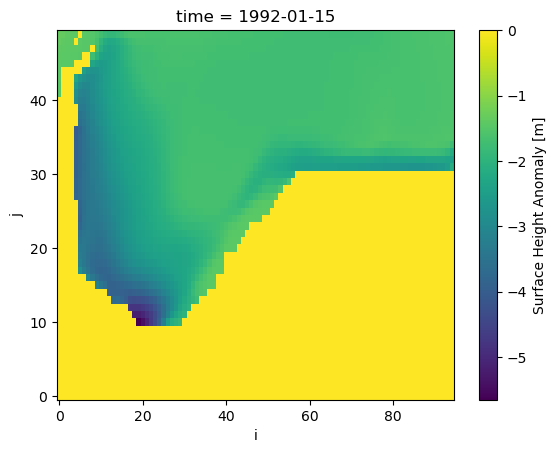

In [14]:
ds.ETAN[0].isel(**lat_range_noface, **lon_range_noface).plot()

In [13]:
ds.ETAN_snp

,Array,Chunk
Bytes,106.42 MiB,31.64 kiB
Shape,"(287, 270, 360)","(1, 90, 90)"
Count,31 Graph Layers,3444 Chunks
Type,float32,numpy.ndarray


In [7]:
coords.hFacC[0]

<xarray.DataArray 'hFacC' (j: 270, i: 360)>
dask.array<getitem, shape=(270, 360), dtype=float32, chunksize=(90, 90), chunktype=numpy.ndarray>
Coordinates:
    k        int64 0
Dimensions without coordinates: j, i
Attributes:
    long_name:      vertical fraction of open cell
    standard_name:  cell_vertical_fraction

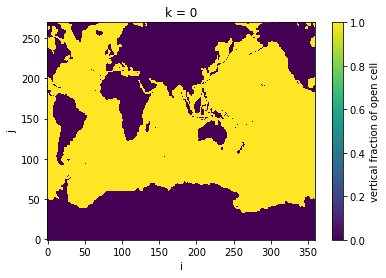

In [14]:
coords.hFacC[0].plot()

In [8]:
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'i', 'left': 'i_g'}, 
                             'Y': {'center': 'j', 'left': 'j_g'},
                             'T': {'center': 'time'},
                             'Z': {'center': 'k', 'left': 'k_l', 'outer': 'k_p1', 'right': 'k_u'}},
                             periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center

In [9]:
def tracer_flux_budget(suffix):
    """Calculate the convergence of fluxes of tracer `suffix` where 
    `suffix` is `TH` or `SLT`. Return a new xarray.Dataset."""
    conv_horiz_adv_flux = -(grid.diff(ds['ADVx_' + suffix], 'X') +
                          grid.diff(ds['ADVy_' + suffix], 'Y', boundary='fill')).rename('conv_horiz_adv_flux_' + suffix)
    conv_horiz_diff_flux = -(grid.diff(ds['DFxE_' + suffix], 'X') +
                          grid.diff(ds['DFyE_' + suffix], 'Y', boundary='fill')).rename('conv_horiz_diff_flux_' + suffix)
    # sign convention is opposite for vertical fluxes
    conv_vert_adv_flux = grid.diff(ds['ADVr_' + suffix], 'Z', boundary='fill').rename('conv_vert_adv_flux_' + suffix)
    conv_vert_diff_flux = (grid.diff(ds['DFrE_' + suffix], 'Z', boundary='fill') +
                           grid.diff(ds['DFrI_' + suffix], 'Z', boundary='fill')).rename('conv_vert_diff_flux_' + suffix)
    
    all_fluxes = [conv_horiz_adv_flux, conv_horiz_diff_flux, conv_vert_adv_flux, conv_vert_diff_flux]
    #conv_all_fluxes = sum(all_fluxes).rename('conv_total_flux_' + suffix)
    #return xr.merge(all_fluxes + [conv_all_fluxes])
    return xr.merge(all_fluxes)

In [14]:
# sum of all converging adv/diff fluxes
budget_slt = tracer_flux_budget('SLT')
budget_slt

<xarray.Dataset>
Dimensions:                   (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>

In [15]:
budget_th = tracer_flux_budget('TH')
budget_th

<xarray.Dataset>
Dimensions:                  (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 1, 89), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 49, 90, 90), meta=np.ndarray>

**Theta Tendency Term**

In [14]:
#calculating total tendency term for heat
theta_scaled = (ds.THETA_snp * (1 + (ds.ETAN_snp / coords.Depth))).diff('time_snp')

#forcing theta_scaled to have same timestamp as ds.dt by creating new data array called "theta_scaled"
theta_scaled = xr.DataArray(theta_scaled.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data})
theta_scaled

<xarray.DataArray 'sub-4d28eea95f170eda413d6eb78affebb4' (time: 286, k: 50, j: 270, i: 360)>
dask.array<sub, shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Dimensions without coordinates: k, j, i

In [15]:
theta_tend = (theta_scaled / coords.dt[1:287])

**Salt Tendency Term**

In [16]:
#calculating total tendency term for salt
salt_scaled = (ds.SALT_snp * (1 + (ds.ETAN_snp / coords.Depth))).diff('time_snp')

#forcing salt_scaled to have same timestamp as ds.dt by creating new data array called "salt_scaled"
salt_scaled = xr.DataArray(salt_scaled.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data})
salt_scaled
#units: g/kg (psu)

<xarray.DataArray 'sub-1f8754662eacbe361056ba5a4f846f01' (time: 286, k: 50, j: 270, i: 360)>
dask.array<sub, shape=(286, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Dimensions without coordinates: k, j, i

In [17]:
salt_tend = (salt_scaled / coords.dt[1:287])
#units: g/kg*s (psu/s)

In [18]:
volume = (coords.drF * coords.rA * coords.hFacC)
#day2seconds = (24*60*60)
totttend = theta_tend * volume
totstend = salt_tend * volume

In [19]:
#adding calculated total tendency
budget_th['total_tendency_TH_truth'] = totttend
budget_slt['total_tendency_SLT_truth'] = totstend

In [20]:
budget_th['total_tendency_TH_truth'] = budget_th.total_tendency_TH_truth.chunk({'time':1})
budget_slt['total_tendency_SLT_truth'] = budget_slt.total_tendency_SLT_truth.chunk({'time':1})

In [21]:
runit2mass = 1.035e3 #kg/m^3
salt_plume = ((ds.oceSPtnd * coords.rA)/runit2mass)#.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})
salt_plume

<xarray.DataArray (time: 288, k: 50, j: 270, i: 360)>
dask.array<truediv, shape=(288, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i

### Surface Fluxes

The surface fluxes are only active in the top model layer. We need to specify some constants to convert to the proper units and scale factors to convert to integral form. They also require some xarray special sauce to merge with the 3D variables.

In [45]:
# constants
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3 #rho
# treat the shortwave flux separately from the rest of the surface flux

#surf flux
surf_flux_th = (ds.TFLUX - ds.oceQsw) * coords.rA * coords.hFacC.isel(k=0) / (heat_capacity_cp * runit2mass)
#w.o `_,` the return would've been the two arrays - hFacC and surf_flux_th - so here, we only want surf_flux_th returned
_, surf_flux_th_aligned = xr.align(coords.hFacC, surf_flux_th.expand_dims('k'), join='outer')
surf_flux_th_aligned = surf_flux_th_aligned.fillna(0.)

#sw flux
surf_flux_th_sw = ds.oceQsw * coords.rA * coords.hFacC.isel(k=0) / (heat_capacity_cp * runit2mass)

#what about `ds.oceFWflx` term for salt budget?
# salt
surf_flux_slt = ds.SFLUX * coords.rA  / runit2mass
surf_flux_slt.coords['k'] = coords.k[0]
_, surf_flux_slt_aligned = xr.align(coords.hFacC, surf_flux_slt.expand_dims('k'), join='outer')
surf_flux_slt_aligned = surf_flux_slt_aligned.fillna(0.)
#units: (˚C m^3)/s

# in order to align the surface fluxes with the rest of the 3D budget terms,
# we need to give them a z coordinate. We can do that with this function
#def surface_to_3d(da):
#    da.coords['k'] = ds.k[0]
#    return da.expand_dims(dim='k', axis=1)

In [23]:
budget_slt['salt_plume'] = salt_plume
budget_slt['surface_flux_SLT'] = surf_flux_slt_aligned

In [44]:
ds.SALT

<xarray.DataArray 'SALT' (time: 288, k: 50, j: 270, i: 360)>
dask.array<rechunk-merge, shape=(288, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i
Attributes:
    long_name:      Salinity
    standard_name:  SALT
    units:          psu

In [43]:
ds.SFLUX

<xarray.DataArray 'SFLUX' (time: 288, j: 270, i: 360)>
dask.array<rechunk-merge, shape=(288, 270, 360), dtype=float32, chunksize=(1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i
Attributes:
    long_name:      total salt flux (match salt-content variations), >0 incre...
    standard_name:  SFLUX
    units:          g/m^2/s

In [41]:
ds.oceFWflx

<xarray.DataArray 'oceFWflx' (time: 288, j: 270, i: 360)>
dask.array<rechunk-merge, shape=(288, 270, 360), dtype=float32, chunksize=(1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i
Attributes:
    long_name:      net surface Fresh-Water flux into the ocean (+=down), >0 ...
    standard_name:  oceFWflx
    units:          kg/m^2/s

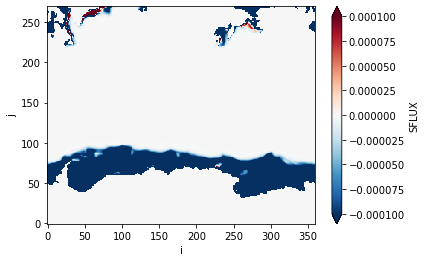

In [37]:
ds.SFLUX.mean(dim='time').plot(vmax=0.0001)

### Shortwave Flux

Special treatment is needed for the shortwave flux, which penetrates into the interior of the water column

In [24]:
def swfrac(coords, fact=1., jwtype=2):
    """Clone of MITgcm routine for computing sw flux penetration.
    z: depth of output levels"""
    
    rfac = [0.58 , 0.62, 0.67, 0.77, 0.78]
    a1 = [0.35 , 0.6  , 1.0  , 1.5  , 1.4]
    a2 = [23.0 , 20.0 , 17.0 , 14.0 , 7.9 ]
    
    facz = fact * coords.Zl.sel(k_l=slice(0, 18))
    j = jwtype-1
    swdk = (rfac[j] * np.exp(facz / a1[j]) +
            (1-rfac[j]) * np.exp(facz / a2[j]))
            
    return swdk.rename('swdk')

_, swdown = xr.align(coords.Zl, surf_flux_th_sw * swfrac(coords), join='left', )
swdown = swdown.fillna(0)

In [25]:
#convergence of swdown
sw = -grid.diff(swdown, 'Z', boundary='fill')
sw

<xarray.DataArray 'sub-c12fbc4365309b3569467261c9e838a8' (time: 288, j: 270, i: 360, k: 50)>
dask.array<neg, shape=(288, 270, 360, 50), dtype=float32, chunksize=(1, 90, 90, 49), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i

In [26]:
budget_th['surface_flux_conv_TH'] = surf_flux_th_aligned#.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})

budget_th['sw_flux_conv_TH'] = sw#.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})

In [16]:
budget_th = budget_th.chunk({'i': -1, 'j': -1, 'k': -1, 'time': 1})
budget_th

<xarray.Dataset>
Dimensions:                  (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>

In [17]:
budget_slt = budget_slt.chunk({'i': -1, 'j': -1, 'k': -1, 'time': 1})
budget_slt

<xarray.Dataset>
Dimensions:                   (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, j
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>

In [18]:
ds_slt_wg.conv_horiz_adv_flux_SLT[0,0].plot()

NameError: name 'ds_slt_wg' is not defined

## Saving Data

In [26]:
gcfs_auth = gcsfs.GCSFileSystem(project='pangeo-181919', token='browser')
token = gcfs_auth.tokens[('pangeo-181919', 'full_control')]
gcfs_w_token = gcsfs.GCSFileSystem(project='pangeo-181919', token=token)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=586241054156-9kst7ltfj66svc342pcn43vp6ta3idin.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&state=l7ic9DnE10QiUrUuTe7WMkbpBZfttU&prompt=consent&access_type=offline


Enter the authorization code:  4/zwFAwLTVqZUu9a1xKfZVkIc4kPzXX3m6S4LVSHZ4OPtrRXvRHUx16Uc


### Saving Data (WG region)
for purpose of getting ECCO working in time for paper - late upload full tmp/slt datasets just in case you change boundaries again

In [18]:
ds_tst = ds.isel(**lat_range_noface, **lon_range_noface)

In [20]:
ds_tst.j

<xarray.DataArray 'j' (j: 50)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
Dimensions without coordinates: j

In [16]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81 #goes from -61.522682 to -61.987038
i_g_right = 119 #31˚E
i_g_left = 22 #66˚W

In [17]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

In [33]:
ds_tmp_wg = budget_th.isel(**lat_range_noface, **lon_range_noface)
ds_slt_wg = budget_slt.isel(**lat_range_noface, **lon_range_noface)

In [33]:
#saving heat budget ds
gcsmap_th_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr')
ds_tmp_wg.to_zarr(gcsmap_th_wg, mode='w')

In [34]:
#saving salt budget ds
gcsmap_slt_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr')
ds_slt_wg.to_zarr(gcsmap_slt_wg, mode='w')